## Import dataset, split it in `heart_target` and `heart_data`

Furthermore, look at the distribution of outcome values

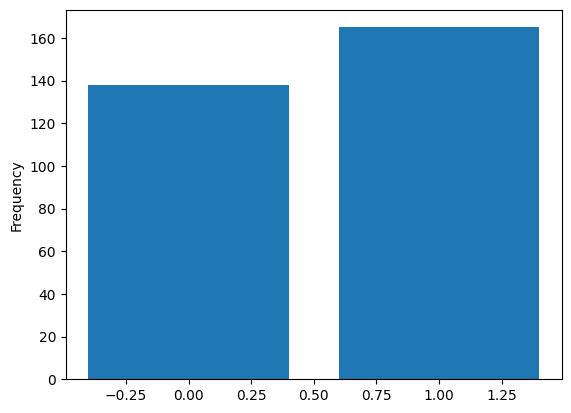

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

heart = pd.read_csv("data/raw_dataset/heart.csv")

from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt

# separate the target variable from the features
heart_target = heart['output']
heart_data = heart.drop('output', axis=1)

# plot the class distribution
class_dist = pd.Series(heart_target).value_counts()
plt.bar(class_dist.index, class_dist)
plt.ylabel("Frequency")
plt.show()

display(heart_data.head())


## Measure the correlation between attributes and the outcome:

-> Especially `fbs` and `trtbps` don't seem to play a big role for the outcome

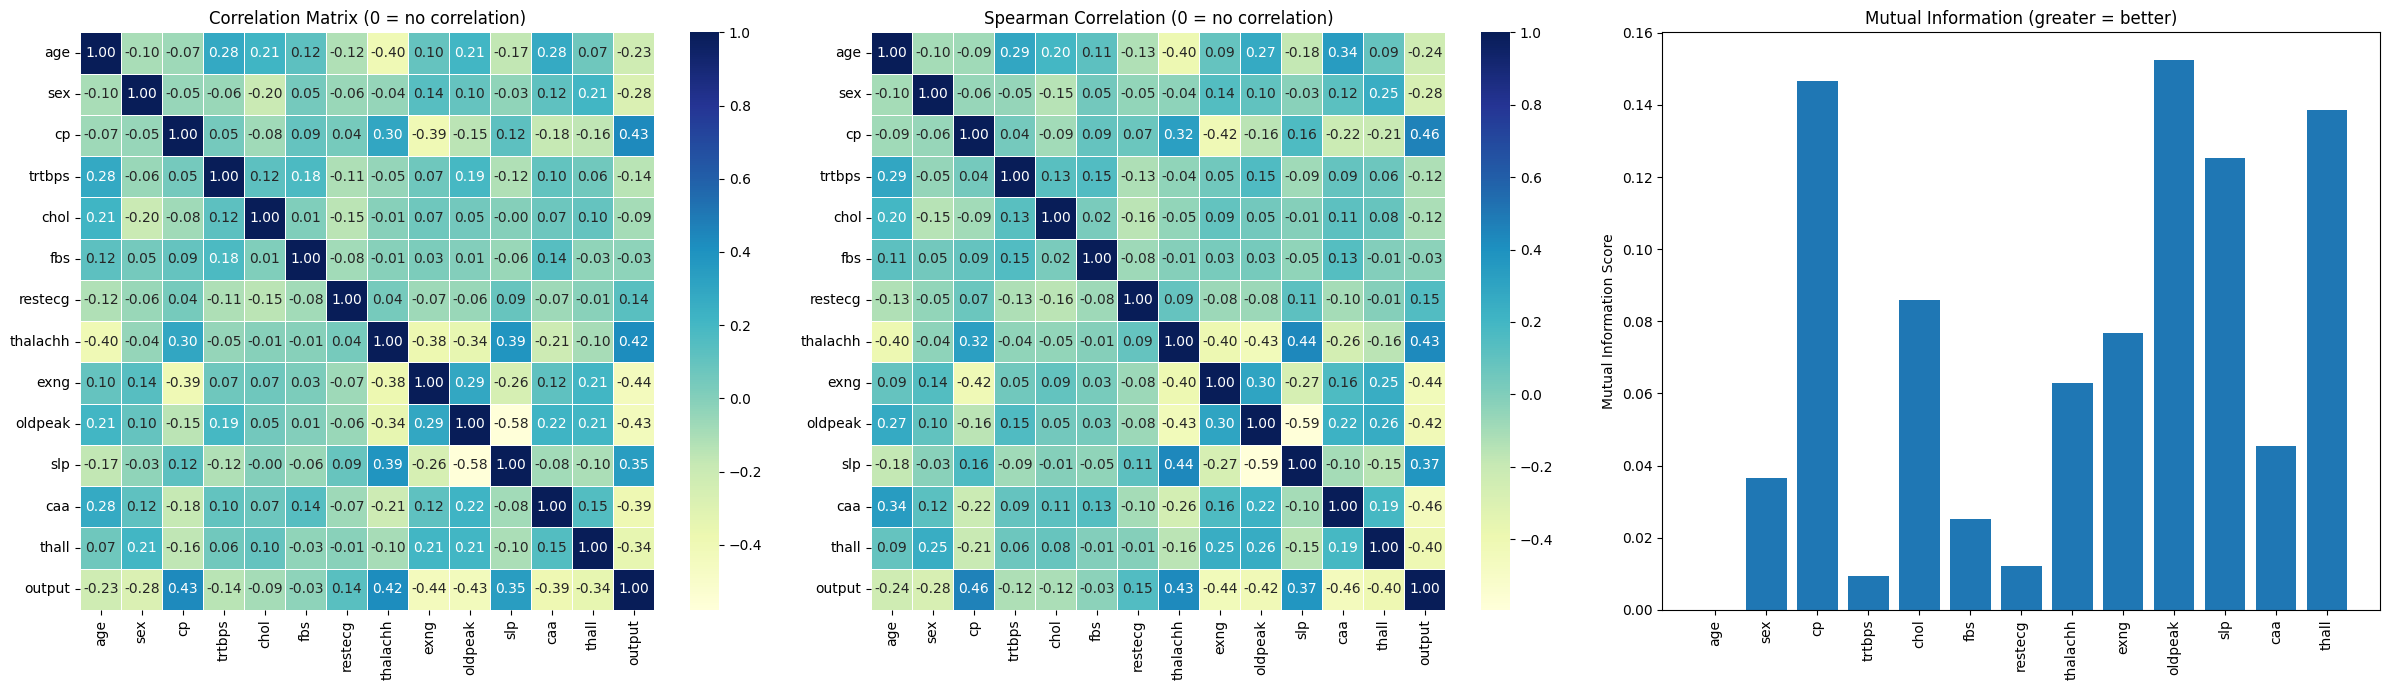

In [84]:
from sklearn.feature_selection import mutual_info_regression

# Correlation matrix
corr_matrix = heart.corr()

# Spearman correlation
spearman_corr = heart.corr(method='spearman')

# Mutual Information
mutual_info = mutual_info_regression(heart_data, heart_target)
mutual_info = pd.Series(mutual_info)
mutual_info.index = heart_data.columns


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(24, 7))

# Plot correlation matrix
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu", 
            ax=axs[0])
axs[0].set_title('Correlation Matrix (0 = no correlation)')

# Plot Spearman correlation
sns.heatmap(spearman_corr, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu", 
            ax=axs[1])
axs[1].set_title('Spearman Correlation (0 = no correlation)')

# Plot Mutual Information
axs[2].bar(mutual_info.index, mutual_info)
plt.xticks(rotation=90)
axs[2].set_ylabel('Mutual Information Score')
axs[2].set_title('Mutual Information (greater = better)')

plt.tight_layout()
plt.show()

## Preprocessing using a pipeline and a **`RandomForestClassifier()`**:

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
# from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# list all numerical features that we want to re-scale
numeric_features = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
numeric_transformer = Pipeline([ ('scaler', StandardScaler()) ])

# list all categorical features that we want to encode using OneHotEncoder
categorical_features = ['cp', 'restecg', 'caa', 'thall', 'slp']
categorical_transformer = Pipeline([ ('onehot', OneHotEncoder()) ])

# list all ordinal features that we want to encode using OrdinalEncoder
ordinal_features = ['sex',  'fbs', 'exng']
ordinal_transformer = Pipeline([ ('ordinal', OrdinalEncoder()) ])

# define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)])

print("Scaled data:")
display(preprocessor.fit_transform(heart_data))

pipeline = Pipeline([ 
    ('preprocessing', preprocessor), 
    # ('balancing', RandomOverSampler()),
    ('estimator', RandomForestClassifier(random_state=42, n_estimators=75)) ])#DecisionTreeClassifier()) ])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


Scaled data:


array([[ 0.9521966 ,  0.76395577, -0.25633371, ...,  1.        ,
         1.        ,  0.        ],
       [-1.91531289, -0.09273778,  0.07219949, ...,  1.        ,
         0.        ,  0.        ],
       [-1.47415758, -0.09273778, -0.81677269, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.50364073,  0.70684287, -1.029353  , ...,  1.        ,
         1.        ,  0.        ],
       [ 0.29046364, -0.09273778, -2.2275329 , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.29046364, -0.09273778, -0.19835726, ...,  0.        ,
         0.        ,  0.        ]])

## First prediction without parameter optimization:

In [64]:
prediction = cross_val_predict(pipeline, heart_data, heart_target, cv=cv)

def cost_function(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred)
    return cm[0][1] * 100 + cm[1][0] * 1

cm = confusion_matrix(heart_target, prediction)
cost = cost_function(heart_target, prediction)
acc = accuracy_score(heart_target, prediction)

print("Decision Tree with accuracy of {} and cost {}".format(acc, cost))
print(cm)
print(classification_report(heart_target, prediction))

Decision Tree with accuracy of 0.8217821782178217 and cost 3123
[[107  31]
 [ 23 142]]
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       138
           1       0.82      0.86      0.84       165

    accuracy                           0.82       303
   macro avg       0.82      0.82      0.82       303
weighted avg       0.82      0.82      0.82       303



## Default Parameters for Decision Tree:

In [32]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Now, find the best params:

Decision Tree with accuracy of 0.83, cost 2923 and recall of 0.86
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       138
           1       0.83      0.86      0.85       165

    accuracy                           0.83       303
   macro avg       0.83      0.83      0.83       303
weighted avg       0.83      0.83      0.83       303



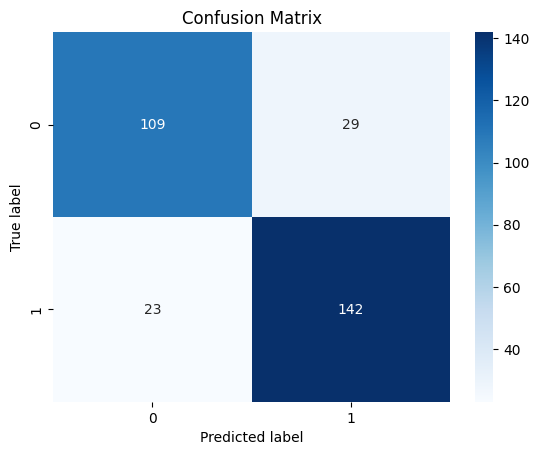

Optimised Parameters: {'estimator__criterion': 'entropy', 'estimator__max_depth': None, 'estimator__min_samples_split': 9}


In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# define the parameter grid
parameters = {
    'estimator__criterion':['gini', 'entropy'], 
    'estimator__max_depth':[ 2, 3, 4, 5, 6, 7, None],
    'estimator__min_samples_split' :[2,3,4,5,6,7,8,9,10]
}

# define the folds for the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# create a scorer for the grid search
cost_score = make_scorer(cost_function, greater_is_better=False)

# create the grid search estimator
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=cost_score, cv=stratified_10_fold_cv)

# cross-validate
prediction = cross_val_predict(grid_search_estimator, heart_data, heart_target, cv=cv, n_jobs=-1)

# calculate costs
cm = confusion_matrix(heart_target, prediction)
cost = cost_function(heart_target, prediction)
acc = accuracy_score(heart_target, prediction)
recall = recall_score(heart_target, prediction)

print("Decision Tree with accuracy of {}, cost {} and recall of {}".format(acc.round(2), cost, recall.round(2)))
print(classification_report(heart_target, prediction))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# fit the grid search (= determine the optimal parameters)
grid_search_estimator.fit(heart_data, heart_target)
print("Optimised Parameters: {}".format(grid_search_estimator.best_params_))

## Later, one would want to predict like that:

Decision Tree with accuracy of 0.83, cost 2627 and recall of 0.84
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       138
           1       0.84      0.84      0.84       165

    accuracy                           0.83       303
   macro avg       0.82      0.82      0.82       303
weighted avg       0.83      0.83      0.83       303



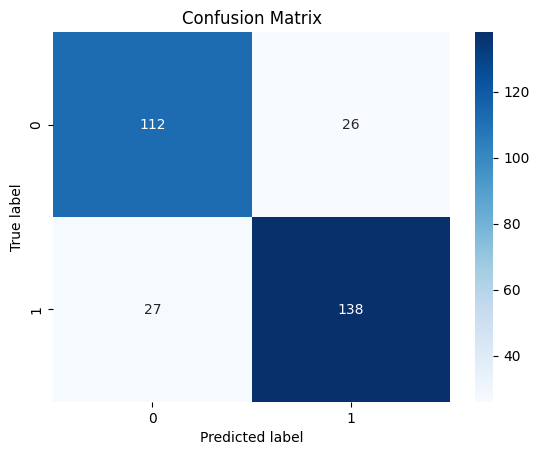

In [83]:
pipeline.set_params(
    estimator__criterion=grid_search_estimator.best_params_['estimator__criterion'],
    estimator__max_depth=grid_search_estimator.best_params_['estimator__max_depth'],
    estimator__min_samples_split=grid_search_estimator.best_params_['estimator__min_samples_split'])

prediction = cross_val_predict(pipeline, heart_data, heart_target, cv=cv)

cm = confusion_matrix(heart_target, prediction)
cost = cost_function(heart_target, prediction)
acc = accuracy_score(heart_target, prediction)
recall = recall_score(heart_target, prediction)

print("Decision Tree with accuracy of {}, cost {} and recall of {}".format(acc.round(2), cost, recall.round(2)))
print(classification_report(heart_target, prediction))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
